# Accessing the ATLAS Open Data

This notebook is based on the use of  ATLAS Open Data 
http://opendata.atlas.cern

ATLAS Open Data provides open access to proton-proton collision data at the LHC. 

The ATLAS Collaboration makes avaliable approximately 1/10 of the data and the corresponding Monte Carlo samples for didactic purposes. 

The data are made available under the form of ROOT ntuples, the contents are:
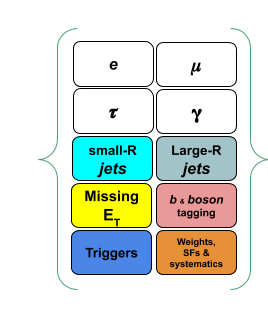


The purpose of this nootebook is to give an example of access to these ntuples based on the uproot package and to load the data onto a panda dataframe 
familiarise ourselves with the content of these ntuples, to learn how to calculate combinations of variables.

The present notebook started from the one provided by ATLAS for the H->ZZ analysis, but it simplifies it to a single file for didactic purposes, and, most important, it speeds it up by avoiding explicit iteration on the events in the ntuples while reading files. The price is a somewhat awkward juggling of data


## Installation of packages not available by default on colab

In [1]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib

!pip install uproot
!pip install vector
!pip install awkward

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Import packages used in the analysis

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us store data as awkward arrays, a format that generalizes numpy to nested data with possibly variable length lists
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd

[Back to contents](#contents)

<a id='fraction'></a>

## Data fraction, file path

General definitions of fraction of data used, where to access the input files

In [3]:
fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/MC/" # web address for MC
#Monte carlo files: uncomment one at a time, otherwise it just picks up the last line
#pp->ZZ->4l
filename = "mc_363490.llll.4lep.root"
#pp -> Higgs->ZZ->4l
#filename = "mc_345060.ggH125_ZZ4lep.4lep.root"
#pp>ttbar->4 leptons (reducible)
#filename="mc_410000.ttbar_lep.4lep.root"
#Data
#tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/Data/" # web address for data
#filename = "data_D.4lep.root"

filestring= tuple_path+filename

<a id='samples'></a>

Units, as stored in the data files. The quantities in the ATLAS ntuple are unfortunately stored in MeV.
Since the natural unit for LHC analysis is GeV, we defineconversion factors

In [4]:
MeV = 0.001
GeV = 1.0

### Example of building a complex variable out of the 4-momenta of the four leptons

Define function to calculate 4-lepton invariant mass.
It accesses the dataframe where the particle data are stored as scalar components, and creates an array of 4-vectors  based on the 'vector' library https://pypi.org/project/vector/

In [5]:
def calc_mllll(dff):
#
#   create array of 4-vectors, one for each lepton
#
    pl=[]
    pl.append(vector.array({"pt":dff["ptl1"], "phi":dff["phil1"], "eta":dff["etal1"], "e":dff["el1"]}))
    pl.append(vector.array({"pt":dff["ptl2"], "phi":dff["phil2"], "eta":dff["etal2"], "e":dff["el2"]}))
    pl.append(vector.array({"pt":dff["ptl3"], "phi":dff["phil3"], "eta":dff["etal3"], "e":dff["el3"]}))
    pl.append(vector.array({"pt":dff["ptl4"], "phi":dff["phil4"], "eta":dff["etal4"], "e":dff["el4"]}))
    return (pl[0]+pl[1]+pl[2]+pl[3]).M

## Example of defining a selection  function

Simple template for a selection function acting on the dataframe, it creates a boolean
only for complex selection, for simple boolean of variables use df.query

In [6]:
def cut_ptl12(df):
#   dummy example, the selection on the tranverse momentum would be done 
#   in a much simpler way as a query, this is just to give a template for more complex
#   selections
    return (df.ptl1>5/MeV)

## Reading in the file

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so the lepton vectors have all dimension 4.

Slightly complex gimmick to create a clean panda dataframe to be used in the following of the 
analysis

Steps:

* Read in the tree with uproot https://pypi.org/project/uproot/, and check number of events and structure of tree
* Define variables of interest which we want to analyse
* Store them into a series of awkward arrays  https://awkward-array.org/doc/main/index.html
* Reformat the arrays to numpy vectors
* Stack them
* Insert them into a Panda dataframe
* Label the columns of the dataframe
* Add composite variables to the dataframe 
* Apply selections to the dataframe
* Return the dataframe

## Meaning of the lepton variables:
* lep_pt, lep_eta, lep_phi, lep_e:  components of 4-momenum of lepton in collider coordinates
* lep_charge: chage of the lepton, +1 or -1
* type of lepton:  electron=11   muon=13
* lep_ptcone30: sum of the transverse momenta of tracks in a cone surrounding the lepton (isolation variable)
* lept_etcone20: sum of transverse momenta of calo cells in a cone surriunding the lepton (isolatin variable)
* lep_isTightID: 0 or 1, it tells if a lepton passes the tight selection criteria for a lepton

In [7]:
def read_file(filestring):
  with uproot.open( filestring + ":mini") as tree:
    numevents = tree.num_entries # number of events
    print(tree.keys())
    print(tree.typenames())
    print(tree.show())

# variables to extract from ntuple
    tupvar=["lep_pt", "lep_eta", "lep_phi","lep_E",
          "lep_charge","lep_type"]
#          "lep_ptcone30","lep_etcone20", "lep_isTightID"]
# read tree into awkward array with uproot
    lep_momentum = tree.arrays(tupvar,entry_stop=numevents*fraction,library="ak")
# define the names of the variables to go into dataframe
    colnam=["ptl1","etal1","phil1","el1","chl1","typl1",
          "ptl2","etal2","phil2","el2","chl2","typl2",
          "ptl3","etal3","phil3","el3","chl3","typl3",
          "ptl4","etal4","phil4","el4","chl4","typl4"]
# create numpy vector assuming that lep_ arrays have 4 components
    for i in range(0,4):
      for j in range(0,len(tupvar)):
        if i==0 and j==0:
          ptlep=ak.to_numpy(lep_momentum[tupvar[j]][:,i])
        else:
          ptlep=np.vstack([ptlep,ak.to_numpy(lep_momentum[tupvar[j]][:,i])])
    print(ptlep.shape)
# end up with numpy 2d vector with n_var rows and n_event columns
# to transpose, as in pandas 'features' are columns and 'observations' rows
    ptlep=ptlep.transpose()
# create dataframe 
    df = pd.DataFrame(ptlep)
# add names of columns
    df.columns=colnam
# add new derived variable
    df["mllll"]=calc_mllll(df)
# apply cuts on variable
#    df=df[cut_ptl1(df)]
    return df

This is where the reading of the file happens

In [8]:
start = time.time() # time at start of whole processing
df=read_file(filestring) # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_PHOTON', 'scaleFactor_TAU', 'scaleFactor_BTAG', 'scaleFactor_LepTRIGGER', 'scaleFactor_PhotonTRIGGER', 'trigE', 'trigM', 'trigP', 'lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'met_et', 'met_phi', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_jvt', 'jet_trueflav', 'jet_truthMatched', 'jet_MV2c10', 'photon_n', 'photon_truthMatched', 'photon_trigMatched', 'photon_pt', 'photon_eta', 'photon_phi', 'photon_E', 'photon_isTightID', 'photon_ptcone30', 'photon_etcone20', 'photon_convType', 'tau_n', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_E', 'tau_isTightID', 'tau_truthMatched', 'tau_trigMatched', 'tau_nTracks', 'tau_BDTid', 'ditau_m', 'lep_pt_syst', 'met_et_syst', 'jet_pt_syst', 'p

(24, 554279)
Time taken: 24.6s


## Apply simple cuts to ntuple using query

First build the selection string, then apply it to the dataframe for creating a new variable

In [9]:
# build the selection string
cutl1=50/MeV
cutl2=5/MeV
strcut="ptl1>"+str(cutl1)+" and ptl2>"+str(cutl2)
print(strcut)
# optionally, create smaller dataframe with only variables on which 
# selection is performed and variable one wants to plot
dfm4l=df.filter(items=['mllll','ptl1','ptl2'])
# create new dataframe after applying selection
dfm4l1=dfm4l.query(strcut)
# print efficiency of cut
print(" before ",dfm4l.shape[0]," after ",dfm4l1.shape[0], " efficiency ", dfm4l1.shape[0]/dfm4l.shape[0])

ptl1>50000.0 and ptl2>5000.0
 before  554279  after  435083  efficiency  0.7849530651531088


## Plotting

Set simple wrapper for plotting histograms with matplotlib

In [10]:
# in input:  df=dataframe var=variable in dataframe, 
# scale=scale factor on value of variable (e.g. for scaling between MeV and GeV)
# nbin,xlow,xhigh: limits of histogram
# norm: choose whether you plot acutal number of events in bin or fraction of events 
#       in each bin with respect to total
# labx, laby labels of x and y axis of histogram 
# title: title of hisotgram
# leg: legenda for content, useful if you superimpose two hists
def hist1d(df, var, scale, nbin, xlow, xhig, norm, labx, laby, title, leg):
  bins = np.linspace(xlow,xhig,nbin)
  plt.hist(df[var]*scale, bins, alpha=0.5, density=norm, label=leg)
  plt.xlabel(labx)
  plt.ylabel(laby)
  plt.legend(loc='best')
# 2d, same definition of inputs as above
def hist2d(df,var1,var2,scalex,scaley,nbinx,xlow,xhig,nbiny,ylow,yhig,labx,laby,title):
  binx = np.linspace(xlow,xhig,nbinx)
  biny = np.linspace(ylow,yhig,nbiny)
  plt.hist2d(df[var1]*scalex, df[var2]*scaley, bins=[binx, biny], density=False, cmin=0.5)
  plt.xlabel(labx)
  plt.ylabel(laby)

Call the functions to plot the data

In [11]:
hist2d(dfm4l,"ptl1","etal1",MeV,1,100,0.,200.,100,-3.,3.,'pt(lep1) [GeV]','pt(lep2) [GeV]','')
plt.show()
hist1d(dfm4l,"mllll",MeV,100,0.,200.,False,'mllll [GeV]','Number of events','','no cuts on ptlep')
hist1d(dfm4l1,"mllll",MeV,100,0.,200.,False,'mllll [GeV]','Number of events','','cuts on ptlep')
plt.show()


KeyError: 'etal1'

<a id='going_further'></a>

## Exercises to familiarise yourself with ntuple

The idea would be that you learn how to apply selection and add variables to a panda dataframe
and you understand the impact of the selections by calculating the efficiencies and histogramming 
the impact on other variables

You may want to perform the exercise below for different files, to see how the variables look
like for different samples. You can do that by commenting and uncommenting names of files
in the  <b>Data-fraction,-file-path</b>  box

Alternatively you may want to create a separate dataframe for each of the input files 
and compare  how the distributions you extract from the exercises below look for different files

* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0040): examples
    * Require that the event includes two different-flavour/opposite charge pairs<br />
    (hint: the sum of charge mutliplied type should be zero)
    * Require that the leptons are isolated, based on the isolation definition of the Higgs paper <br />
    (pt in  cone)/(pt of lepton)<0.2 and (et_in cone)/(pt of lepton)<0.2
    * Require that both leptons pass tight isolation 
* After each cut calculate the efficiency of the cut
* Plot the distribution of the mllll variable after each of the cuts
* (difficult) Add m12 variable, as defined in paper:<br />
   among the different-flavour/opposite-sign pairs select the one whose invariant mass is nearest to the Z mass    (91.12 GeV),<br /> 
   and plot it
* (simple) add the angular distance between the two leading leptons (1 and 2) using the vector library https://pypi.org/project/vector/ and plot it